In [2]:
from wotan import flatten
import numpy as np
from nuance.utils import transit
import tinygp
import jax
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
import sys

sys.path.append("./lib")
sys.path.append("../lib")
from utils import white_red

seed = 42


/Users/lgrcia/code/dev/nuance/nuance/nuance.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [1]:
# Simulate light curve
# --------------------
np.random.seed(seed)
# transit
time = np.linspace(0, 3, 1000)
dur = 0.1
depth = 0.8e-2
n = dur / np.median(np.diff(time))
signal = transit(time, time.mean(), dur, depth, c=10) + 1.0

# white noise
wsigma = 1.5e-3
white_noise = np.random.normal(0, wsigma, len(time))
flux = white_noise + signal


NameError: name 'np' is not defined

In [4]:
# Simulate variability
# --------------------
lightcurves = []
variabilities = []
gps = []
cond_gps = []

periods = [1000.0, 1.0, 0.2, 0.1, 0.04]
amps = [0.0, 1e-2, 1e-2, 1e-2, 5e-3]

for i, (period, amp) in enumerate(zip(periods, amps)):
    Q = 10.0
    w0 = 1 / period
    S0 = amp

    var_kernel = tinygp.kernels.quasisep.SHO(w0, Q, S0)
    gp = tinygp.GaussianProcess(var_kernel, time, mean=0.0)
    cond_gp = tinygp.GaussianProcess(var_kernel, time, mean=0.0, diag=wsigma**2)
    variability = gp.sample(jax.random.PRNGKey(seed))
    variability -= np.median(variability)
    flux = white_noise + signal + variability
    lightcurves.append(flux)
    variabilities.append(variability)
    gps.append(gp)
    cond_gps.append(cond_gp)


In [5]:
# Trends and SNR
# -------------
wotan_trend_snr = []
gp_trend_snr = []

cut = 200
intransit = signal < (1.0 - depth / 2)

# another way
# w, r = white_red(
#    time[~intransit][cut:-cut],
#    flatten_flux[~intransit][cut:-cut],
#    wsigma, mean=np.median(flatten_flux))

for i, (flux, var, gp) in enumerate(zip(lightcurves, variabilities, cond_gps)):
    # WOTAN
    flatten_flux, flatten_trend = flatten(
        time, flux, window_length=3 * dur, return_trend=True
    )
    new_depth = np.max(
        [
            0,
            np.mean(flatten_flux[~intransit][cut:-cut])
            - np.mean(flatten_flux[intransit]),
        ]
    )
    w = wsigma
    r = np.max([0, np.std(flatten_flux[~intransit]) - w])
    SNR = new_depth / np.sqrt((w**2) / n + r**2)
    wotan_trend_snr.append((flatten_trend, SNR))

    # GP
    _, cond = gp.condition(y=flux - 1.0, X_test=time)
    variability_model = cond.mean + 1.0
    flatten_flux = flux - variability_model + 1.0
    new_depth = np.max(
        [
            0,
            np.mean(flatten_flux[~intransit][cut:-cut])
            - np.mean(flatten_flux[intransit]),
        ]
    )
    w = wsigma
    r = np.max([0, np.std(flatten_flux[~intransit]) - w])
    SNR = new_depth / np.sqrt((w**2) / n + r**2)
    gp_trend_snr.append((variability_model, SNR))


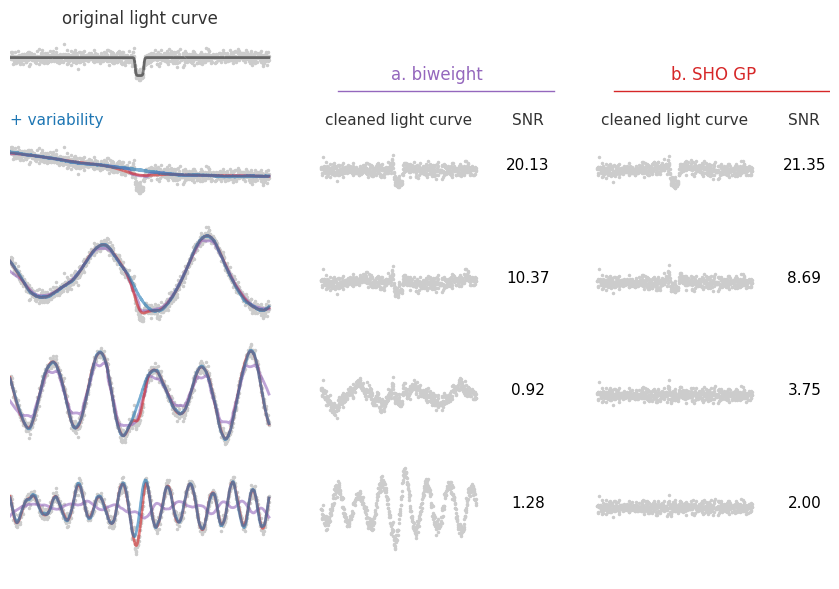

In [26]:
# Plots
# -----
offset = 0.05
plt.figure(figsize=(8.5, 6))

wotan_color = "C4"
gp_color = "C3"

intransit = signal < (1.0 - depth / 2)

x_wotan = 3
x_gp = 6.2

snr_offset = 0.6

for i, (flux, var, gp) in enumerate(zip(lightcurves, variabilities, gps)):
    plt.plot(time, flux - offset * i, ".", c="0.8", ms=3)
    if i == 0:
        plt.plot(time, signal - offset * i, c="k", alpha=0.5, lw=2, ms=3)

    # wotan
    trend, snr = wotan_trend_snr[i]
    if i != 0:
        plt.plot(time, trend - offset * i, c=wotan_color, alpha=0.6, lw=2)
        plt.text(
            time[-cut] + x_wotan + snr_offset,
            1 - i * offset,
            f"{snr:.2f}",
            ha="center",
            fontsize=11,
        )
        plt.plot(
            time[cut:-cut] + x_wotan,
            (flux - trend)[cut:-cut] - offset * i + 1.0,
            ".",
            c="0.8",
            ms=3,
        ),

    # gp
    trend, snr = gp_trend_snr[i]
    if i != 0:
        plt.plot(time, trend - offset * i, c=gp_color, alpha=0.6, lw=2)
        plt.text(
            time[-cut] + x_gp + snr_offset,
            1 - i * offset,
            f"{snr:.2f}",
            ha="center",
            fontsize=11,
        )
        plt.plot(
            time[cut:-cut] + x_gp,
            (flux - trend)[cut:-cut] - offset * i + 1.0,
            ".",
            c="0.8",
            ms=3,
        )

    if i != 0:
        plt.plot(time, var + 1 - offset * i, c="C0", alpha=0.6, lw=2)


txt_color = "0.2"

plt.text(
    time.mean(),
    1.015,
    "original light curve",
    ha="center",
    fontsize=12,
    color=txt_color,
)
plt.text(
    time.min(), 1.02 - offset, "+ variability", ha="left", alpha=1, c="C0", fontsize=11
)

OFFSET = 1


# wotan txt
def text(x, method, color):
    xrange = np.array([0, 2.5]) + x + 0.7
    plt.text(xrange.mean(), OFFSET - 0.01, method, ha="center", c=color, fontsize=12)
    plt.plot(xrange + 0.1, (OFFSET - 0.015, OFFSET - 0.015), "-", c=color, lw=1)
    plt.text(
        time[-cut] + x + snr_offset,
        OFFSET - 0.03,
        "SNR",
        ha="center",
        fontsize=11,
        c=txt_color,
    )
    plt.text(
        time[cut:-cut].mean() + x,
        OFFSET - 0.03,
        "cleaned light curve",
        ha="center",
        fontsize=11,
        c=txt_color,
    )


text(x_wotan, "a. biweight", wotan_color)
text(x_gp, "b. SHO GP", gp_color)

plt.axis("off")
plt.tight_layout()
plt.xlim(0, 9.5)
plt.savefig("../figures/issue2.pdf")
